# Loading Data and Cleaning

In [1]:
#import basic system functions
import os
import datetime
from collections import Counter

#import libraries for data wrangling
import pandas as pd
import numpy as np

#import libraries for plotting data
import matplotlib.pyplot as plt


%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.plotting import autocorrelation_plot



#import libraries for time series analysis
#from fbprophet import Prophet
from pylab import rcParams
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')


from IPython.display import Image
from datetime import datetime

<span style='font-family:Tahoma'>   </span>

In [2]:
df = pd.read_csv("/Users/brittarover/Capstone/Meteolytics/meteolytix_Artikelgruppen_Umsatz_verschiedeneStandorte.csv")

In [3]:
# Renaming Columnlabels
df['Artikelgruppe']=df['Artikelgruppe'].apply(lambda x: 'Weizenbrot' if x==1 else "Mischbrot" if x==2 else 
                    "Vollkornbrot" if x==3 else "Spezialbrot" if x==4 else "Stangenbrote" if x==5 else "Brötchen"
                                                  if x==6 else "Süsse_Brötchen" if x==7 else
                                              "Herzhafte_Brötchen" if x==8 else "KonditoreiBlech1" if x==9
                                                  else "KonditoreiBlech2" if x==10 else "Stückgebäck" 
                                              if x==11 else
                                              "Blechkuchen" if x==12 else "Weihnachtsartikel" )

In [4]:
df.head()

,Filiale,Datum,Artikelgruppe,Umsatz
0,1,2015-01-07,Weizenbrot,50.092235
1,1,2015-01-27,Weizenbrot,57.002341
2,1,2015-01-30,Weizenbrot,52.920825
3,1,2015-02-02,Weizenbrot,89.343474
4,1,2015-02-05,Weizenbrot,68.717498



### Definitions

- **Filiale** - There are three different filial stores which are analyzed, one direct in the city (filiale=1), one near the water front (filiale=2) and the third in a residential area (filiale=3)
1 = city; 2 = waterfront area; 3 = city disctrict
- **Datum** - date of the sales data. The period 
- **Warengruppe** - main article group
1 = Brot; 2 = Brötchen; 3 = Spezial_Brötchen; 4 = Konditorei; 5 = Kuchen; 6 = Weihnachtsartikel    
- **Artikelgruppe** - article group
1 = Weizenbrot; 2 = Mischbrot; 3 = Vollkornbrot; 4 = Spezialbrot; 5 = Stangenbrote; 6 = Brötchen; 7 = Süße Brötchen; 8 = Herzhafte Brötchen; 9 = KonditoreiBlech1; 10 = KonditoreiBlech2; 11 = Stückgebäck; 12 = Blechkuchen; 13 = Weiohnachtsartikel;     
- **Umsatz** - Sales volumne per day and article group   

### Modify Dataframe with groupby and unstack 

In [5]:
df_new=pd.pivot_table(df, values='Umsatz', index=['Datum','Filiale'],columns=['Artikelgruppe'], 
                        aggfunc=np.sum, fill_value=0).reset_index()

In [6]:
#create empty dataframe with 'complete' datetime index
date_df = pd.DataFrame(index=pd.date_range(start='1/1/2015', end=df.Datum.max()))
df_new_1 = pd.pivot_table(df[df.Filiale == 1], values='Umsatz', index=['Datum'],columns=['Artikelgruppe'], 
                        aggfunc=np.sum, fill_value=0)
#fill missing days due to store closings with 0 
df_new_1=df_new_1.merge(date_df, how='right', left_index= True,right_index=True).fillna(0)
df_new_1.index = df_new_1.index.set_names(['Datum'])
df_new_1=df_new_1.reset_index()

df_new_2 = pd.pivot_table(df[df.Filiale == 2], values='Umsatz', index=['Datum'],columns=['Artikelgruppe'], 
                        aggfunc=np.sum, fill_value=0)
#fill missing days due to store closings with 0 
df_new_2 = df_new_2.merge(date_df, how='right',left_index= True,right_index=True).fillna(0)
df_new_2.index = df_new_2.index.set_names(['Datum'])
df_new_2=df_new_2.reset_index()

df_new_3 = pd.pivot_table(df[df.Filiale == 3], values='Umsatz', index=['Datum'],columns=['Artikelgruppe'], 
                        aggfunc=np.sum, fill_value=0)
#fill missing days due to store closings with 0 
df_new_3 = df_new_3.merge(date_df, how='right',left_index= True,right_index=True).fillna(0)
df_new_3.index = df_new_3.index.set_names(['Datum'])
df_new_3=df_new_3.reset_index()

### Transformation to Datetime

In [7]:
# Transformation to Datetime
list=[df,df_new,df_new_1,df_new_2,df_new_3]

for i in list:
  i['Datum'] = pd.to_datetime(i['Datum'])


### Additional Date columns

In [8]:
for i in list:
   i['Wochentag']=i['Datum'].dt.weekday
   i['Jahr']=i['Datum'].dt.year
   i['Monat']=i['Datum'].dt.month
   i['Wochenende']=i['Wochentag'].apply(lambda x: 'Wochentag' if x in (0,1,2,3,4) else 'Wochenende')
    

### Adding a Gesamt Column

In [9]:
#Adding a Gesamt column to all the new dataframes which contains the total sales
list=[df_new,df_new_1,df_new_2,df_new_3]

for i in list:
    i['Gesamt']=i['Vollkornbrot']+i['Mischbrot']+i['Stangenbrote']+i['Weizenbrot']+i['Spezialbrot']+i['Brötchen']
    +i['Süsse_Brötchen']+i['Herzhafte_Brötchen']+i['KonditoreiBlech1']+i['KonditoreiBlech2']+i['Blechkuchen']
    +i['Weihnachtsartikel']+i['Stückgebäck']

In [10]:
df_new_index = df_new.set_index('Datum')


### Definition of KonditoreiBlech as Sum

In [11]:
#KonditoreiBlech1 is only sold until 2019, so I build the sum of both caketypes
for i in list:
  i['KonditoreiBlech1']=i['KonditoreiBlech1']+i['KonditoreiBlech2']
  i.rename(columns={'KonditoreiBlech1':'KonditoreiBlech'}, inplace=True)
  i.drop('KonditoreiBlech2',axis='columns', inplace=True)

# Boxplots

## Filiale 1

### Brötchen

Text(0.5, 1.0, 'Sales per Weekday and articlegroup Brötchen')

<Figure size 1440x216 with 0 Axes>

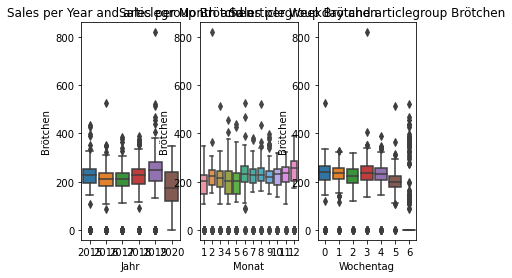

In [13]:
#plot boxplots for Brötchen in first store
plt.figure(figsize=(20,3))

fig, (ax1, ax2,ax3) = plt.subplots(1, 3)

sns.boxplot(data=df_new_1,x='Jahr',y='Brötchen',ax=ax1).set_title(f'Sales per Year and articlegroup Brötchen')
sns.boxplot(data=df_new_1,x='Monat',y='Brötchen',ax=ax2).set_title(f'Sales per Month and articlegroup Brötchen')                  
sns.boxplot(data=df_new_1,x='Wochentag',y='Brötchen',ax=ax3).set_title(f'Sales per Weekday and articlegroup Brötchen')


### Süße Brötchen

In [ ]:
#plot boxplots for each article in first store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)

sns.boxplot(data=df_new_3,x='Jahr',y='Süsse_Brötchen',ax=ax1).set_title(f'Sales per Year and articlegroup Süße Brötchen')
sns.boxplot(data=df_new_1,x='Monat',y='Süsse_Brötchen',ax=ax2).set_title(f'Sales per Month and articlegroup Süße Brötchen')
sns.boxplot(data=df_new_1,x='Wochentag',y='Süsse_Brötchen',ax=ax3).set_title(f'Sales per Weekday and articlegroup Süße Brötchen')                                                                

### Herzhafte Brötchen

In [ ]:
#plot boxplots for Herzhafte Brötchen in first store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)

sns.boxplot(data=df_new_1,x='Jahr',y='Herzhafte_Brötchen',ax=ax1).set_title(f'Sales per Year and articlegroup Herzhafte Brötchen')
sns.boxplot(data=df_new_1,x='Monat',y='Herzhafte_Brötchen',ax=ax2).set_title(f'Sales per Month and articlegroup Herzhafte Brötchen')
sns.boxplot(data=df_new_1,x='Wochentag',y='Herzhafte_Brötchen',ax=ax3).set_title(f'Sales per Weekday and articlegroup Herzhafte Brötchen')

### Blechkuchen

In [ ]:
#plot boxplots for Blechkuchen in first store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Blechkuchen'
sns.boxplot(data=df_new_1,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### KonditoreiBlech

In [ ]:
#plot boxplots for KonditoreiBlech in first store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)

name='KonditoreiBlech'
sns.boxplot(data=df_new_1,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Stückgebäck

In [ ]:
#plot boxplots for Stückgebäck in first store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Stückgebäck'
sns.boxplot(data=df_new_1,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Stangenbrote

In [ ]:
#plot boxplots for Stangenbrote in first store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Stangenbrote'

sns.boxplot(data=df_new_1,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')                  
sns.boxplot(data=df_new_1,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Weizenbrot

In [ ]:
#plot boxplots for Weizenbrot in first store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Weizenbrot'
sns.boxplot(data=df_new_1,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Mischbrot

In [ ]:
#plot boxplots for Mischbrot in first store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Mischbrot'
sns.boxplot(data=df_new_1,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')                  
sns.boxplot(data=df_new_1,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Vollkornbrot

In [ ]:
#plot boxplots for Volkornbrot in first store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Vollkornbrot'
sns.boxplot(data=df_new_1,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Spezialbrot

In [ ]:
#plot boxplots for Spezialbrot in first store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Spezialbrot'
sns.boxplot(data=df_new_1,x='Monat',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Weihnachtsartikel

## Filiale 2

### Brötchen

In [ ]:
#plot boxplots for Brötchen in second store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)

sns.boxplot(data=df_new_2,x='Jahr',y='Brötchen',ax=ax1).set_title(f'Sales per Jahr and articlegroup Brötchen')
sns.boxplot(data=df_new_2,x='Monat',y='Brötchen',ax=ax2).set_title(f'Sales per Month and articlegroup Brötchen')
sns.boxplot(data=df_new_2,x='Wochentag',y='Brötchen',ax=ax3).set_title(f'Sales per Weekday and articlegroup Brötchen')                                                                    

### Süße Brötchen

In [ ]:
#plot boxplots for each article in second store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)

sns.boxplot(data=df_new_2,x='Jahr',y='Süsse_Brötchen',ax=ax1).set_title(f'Sales per Jahr and articlegroup Süße Brötchen')
sns.boxplot(data=df_new_2,x='Monat',y='Süsse_Brötchen',ax=ax2).set_title(f'Sales per Month and articlegroup Süße Brötchen')
sns.boxplot(data=df_new_2,x='Wochentag',y='Süsse_Brötchen',ax=ax3).set_title(f'Sales per Weekday and articlegroup Süße Brötchen')                                                                

### Herzhafte Brötchen

In [ ]:
#plot boxplots for Herzhafte Brötchen in second store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)

sns.boxplot(data=df_new_2,x='Jahr',y='Herzhafte_Brötchen',ax=ax1).set_title(f'Sales per Year and articlegroup Herzhafte Brötchen')
sns.boxplot(data=df_new_2,x='Monat',y='Herzhafte_Brötchen',ax=ax2).set_title(f'Sales per Month and articlegroup Herzhafte Brötchen')
sns.boxplot(data=df_new_2,x='Wochentag',y='Herzhafte_Brötchen',ax=ax3).set_title(f'Sales per Weekday and articlegroup Herzhafte Brötchen')

### Blechkuchen

In [ ]:
#plot boxplots for Blechkuchen in second store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Blechkuchen'
sns.boxplot(data=df_new_2,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### KonditoreiBlech

In [ ]:
#plot boxplots for KonditoreiBlech in second store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='KonditoreiBlech'
sns.boxplot(data=df_new_2,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Stückgebäck

In [ ]:
#plot boxplots for Stückgebäck in second store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Stückgebäck'
sns.boxplot(data=df_new_2,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Stangenbrote

In [ ]:
#plot boxplots for Stangenbrote in second store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Stangenbrote'
sns.boxplot(data=df_new_2,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')                  
sns.boxplot(data=df_new_2,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Weizenbrot

In [ ]:
#plot boxplots for Weizenbrot in second store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Weizenbrot'
sns.boxplot(data=df_new_2,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')                  
sns.boxplot(data=df_new_2,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Mischbrot

In [ ]:
#plot boxplots for Mischbrot in second store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Mischbrot'
sns.boxplot(data=df_new_2,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Vollkornbrot

In [ ]:
#plot boxplots for Volkornbrot in second store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Vollkornbrot'
sns.boxplot(data=df_new_2,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Spezialbrot

In [ ]:
#plot boxplots for Spezialbrot in second store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Spezialbrot'
sns.boxplot(data=df_new_2,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Weihnachtsartikel

## Filiale 3

### Brötchen

In [ ]:
#plot boxplots for Brötchen in third store
plt.figure(figsize=(10,3))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

sns.boxplot(data=df_new_3,x='Jahr',y='Brötchen',ax=ax1).set_title(f'Sales per Year and articlegroup Brötchen')
sns.boxplot(data=df_new_3,x='Monat',y='Brötchen',ax=ax2).set_title(f'Sales per Month and articlegroup Brötchen')
sns.boxplot(data=df_new_3,x='Wochentag',y='Brötchen',ax=ax3).set_title(f'Sales per Weekday and articlegroup Brötchen')                                                                    

### Süße Brötchen

In [ ]:
#plot boxplots for each article in third store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)

sns.boxplot(data=df_new_3,x='Jahr',y='Süsse_Brötchen',ax=ax1).set_title(f'Sales per Year and articlegroup Süße Brötchen')

sns.boxplot(data=df_new_3,x='Monat',y='Süsse_Brötchen',ax=ax2).set_title(f'Sales per Month and articlegroup Süße Brötchen')
                  
sns.boxplot(data=df_new_3,x='Wochentag',y='Süsse_Brötchen',ax=ax3).set_title(f'Sales per Weekday and articlegroup Süße Brötchen')                                                                

### Herzhafte Brötchen

In [ ]:
#plot boxplots for Herzhafte Brötchen in third store
plt.figure(figsize=(10,3))
fig, (ax1, ax2) = plt.subplots(1, 2)


sns.boxplot(data=df_new_3,x='Monat',y='Herzhafte_Brötchen',ax=ax1).set_title(f'Sales per Month and articlegroup Herzhafte Brötchen')
                  
sns.boxplot(data=df_new_3,x='Wochentag',y='Herzhafte_Brötchen',ax=ax2).set_title(f'Sales per Weekday and articlegroup Herzhafte Brötchen')

### Blechkuchen

In [ ]:
#plot boxplots for Blechkuchen in third store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Blechkuchen'
sns.boxplot(data=df_basismodel2_3,x='Jahr',y='Brötchen',ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_basismodel2_3,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_basismodel2_3,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### KonditoreiBlech

In [ ]:
#plot boxplots for KonditoreiBlech in third store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='KonditoreiBlech'
sns.boxplot(data=df_basismodel2_3,x='Jahr',y='Brötchen',ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_basismodel2_3,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_basismodel2_3,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Stückgebäck

In [ ]:
#plot boxplots for Stückgebäck in third store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Stückgebäck'

sns.boxplot(data=df_basismodel2_3,x='Jahr',y='Brötchen',ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_basismodel2_3,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_basismodel2_3,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Stangenbrote

In [ ]:
#plot boxplots for Stangenbrote in third store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Stangenbrote'
sns.boxplot(data=df_basismodel2_3,x='Jahr',y='Brötchen',ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_basismodel2_3,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_basismodel2_3,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Weizenbrot

In [ ]:
#plot boxplots for Weizenbrot in third store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Weizenbrot'
sns.boxplot(data=df_basismodel2_3,x='Jahr',y='Brötchen',ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_basismodel2_3,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_basismodel2_3,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Mischbrot

In [ ]:
#plot boxplots for Mischbrot in third store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Mischbrot'
sns.boxplot(data=df_new_3,x='Jahr',y='Brötchen',ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_3,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_3,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Vollkornbrot

In [ ]:
#plot boxplots for Volkornbrot in third store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Vollkornbrot'
sns.boxplot(data=df_new_3,x='Jahr',y='Brötchen',ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_3,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_3,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Spezialbrot

In [ ]:
#plot boxplots for Spezialbrot in third store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Spezialbrot'
sns.boxplot(data=df_new_3,x='Jahr',y='Brötchen',ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_3,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_3,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Weihnachtsartikel

# Histogramms

## Filiale 1

In [ ]:
df_model_1=df_new_1.iloc[:,1:12]

In [ ]:
_ = df_model_1.hist(figsize=(12,12))


## Filiale 2

In [ ]:
df_model_2=df_new_2.iloc[:,1:12]

In [ ]:
_ = df_model_2.hist(figsize=(12,12))

## Filiale 3

In [ ]:
df_model_3=df_new_3.iloc[:,1:12]

In [ ]:
_ = df_model_3.hist(figsize=(12,12))